<a href="https://colab.research.google.com/github/williamedwardhahn/AI_Microscopy/blob/main/MPCR_Detecto_Blood_Cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src ="https://www.scientistcindy.com/uploads/8/5/1/2/85124478/blood-slide_4_orig.png">

First, mount your drive to give the notebook access to your Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Next, change directory to wherever you created your folder. 

In [2]:
import os

# TODO: Change this to your Drive folder location
WORKING_DIRECTORY = '/content/drive/My Drive/Detect/BCCD/'

os.chdir(WORKING_DIRECTORY)

In [3]:
ls

 Images/      Test_Annotations/    train.csv     'val (1).gsheet'   val.csv
 ImageSets/   Train_Annotations/   train.gsheet  'val (2).gsheet'   val.gsheet


In [4]:
# List the contents of your working directory
# It should contain at least three folders: images, train_labels, and val_labels
!ls

 Images      Test_Annotations	 train.csv     'val (1).gsheet'   val.csv
 ImageSets   Train_Annotations	 train.gsheet  'val (2).gsheet'   val.gsheet


In [5]:
# Note: if it states you must restart the runtime in order to use a
# newly installed version of a package, you do NOT need to do this. 
!pip install detecto

Import everything we need in the following code block:

In [16]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torchvision import transforms
from detecto import core, utils, visualize

To check that everything's working, we can try reading in one of the images from our images folder. 

In [7]:
ls

 Images/      Test_Annotations/    train.csv     'val (1).gsheet'   val.csv
 ImageSets/   Train_Annotations/   train.gsheet  'val (2).gsheet'   val.gsheet


In [ ]:
os.listdir('/content/drive/My Drive/Detect/BCCD/Images/')

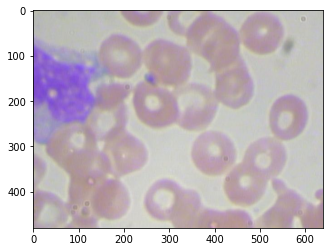

In [9]:
image = utils.read_image('/content/drive/My Drive/Detect/BCCD/Images/BloodImage_00232.jpg')
plt.imshow(image)
plt.show()

In [10]:
# utils.xml_to_csv('Train_Annotations', 'train.csv')
# utils.xml_to_csv('Test_Annotations', 'val.csv')

Below, we create our dataset, applying a couple of transforms beforehand. These are optional, but they can be useful for augmenting your dataset without gathering more data. 

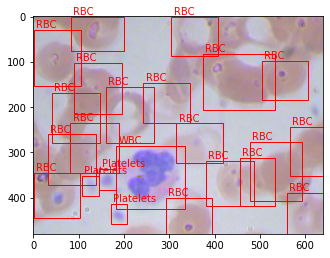

In [11]:
# Specify a list of transformations for our dataset to apply on our images
transform_img = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.Resize(800),
    # transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    utils.normalize_transform(),
])

dataset = core.Dataset('train.csv', 'Images/', transform=transform_img)

# dataset[i] returns a tuple containing our transformed image and
# and a dictionary containing label and box data
image, target = dataset[0]

# Show our image along with the box. Note: it may
# be colored oddly due to being normalized by the 
# dataset and then reverse-normalized for plotting
visualize.show_labeled_image(image, target['boxes'], target['labels'])

Finally, let's train our model! First, we create a DataLoader over our dataset to specify how we feed the images into our model. We also use our validation dataset to track the accuracy of the model throughout training. 

In [12]:
ls

 Images/      Test_Annotations/    train.csv     'val (1).gsheet'   val.csv
 ImageSets/   Train_Annotations/   train.gsheet  'val (2).gsheet'   val.gsheet


In [29]:
import os
import pandas as pd
import random
import torch
import torchvision

from detecto.config import config
from detecto.utils import default_transforms, filter_top_predictions, xml_to_csv, _is_iterable, read_image
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm


class DataLoader(torch.utils.data.DataLoader):

    def __init__(self, dataset, **kwargs):
        """Accepts a :class:`detecto.core.Dataset` object and creates
        an iterable over the data, which can then be fed into a
        :class:`detecto.core.Model` for training and validation.
        Extends PyTorch's `DataLoader
        <https://pytorch.org/docs/stable/data.html>`_ class with a custom
        ``collate_fn`` function.

        :param dataset: The dataset for iteration over.
        :type dataset: detecto.core.Dataset
        :param kwargs: (Optional) Additional arguments to customize the
            DataLoader, such as ``batch_size`` or ``shuffle``. See `docs
            <https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader>`_
            for more details.
        :type kwargs: Any

        **Example**::

            >>> from detecto.core import Dataset, DataLoader

            >>> dataset = Dataset('labels.csv', 'images/')
            >>> loader = DataLoader(dataset, batch_size=2, shuffle=True)
            >>> for images, targets in loader:
            >>>     print(images[0].shape)
            >>>     print(targets[0])
            torch.Size([3, 1080, 1720])
            {'boxes': tensor([[884, 387, 937, 784]]), 'labels': ['person']}
            torch.Size([3, 1080, 1720])
            {'boxes': tensor([[   1,  410, 1657, 1079]]), 'labels': ['car']}
            ...
        """

        super().__init__(dataset, collate_fn=DataLoader.collate_data, **kwargs)

    # Converts a list of tuples into a tuple of lists so that
    # it can properly be fed to the model for training
    @staticmethod
    def collate_data(batch):
        images, targets = zip(*batch)
        return list(images), list(targets)


class Dataset(torch.utils.data.Dataset):

    def __init__(self, label_data, image_folder=None, transform=None):
        """Takes in the path to the label data and images and creates
        an indexable dataset over all of the data. Applies optional
        transforms over the data. Extends PyTorch's `Dataset
        <https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset>`_.

        :param label_data: Can either contain the path to a folder storing
            the XML label files or a CSV file containing the label data.
            If a CSV file, the file should have the following columns in
            order: ``filename``, ``width``, ``height``, ``class``, ``xmin``,
            ``ymin``, ``xmax``, ``ymax`` and ``image_id``. See
            :func:`detecto.utils.xml_to_csv` to generate CSV files in this
            format from XML label files.
        :type label_data: str
        :param image_folder: (Optional) The path to the folder containing the
            images. If not specified, it is assumed that the images and XML
            files are in the same directory as given by `label_data`. Defaults
            to None.
        :type image_folder: str
        :param transform: (Optional) A torchvision `transforms.Compose
            <https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose>`__
            object containing transformations to apply on all elements in
            the dataset. See `PyTorch docs
            <https://pytorch.org/docs/stable/torchvision/transforms.html>`_
            for a list of possible transforms. When using transforms.Resize
            and transforms.RandomHorizontalFlip, all box coordinates are
            automatically adjusted to match the modified image. If None,
            defaults to the transforms returned by
            :func:`detecto.utils.default_transforms`.
        :type transform: torchvision.transforms.Compose or None

        **Indexing**:

        A Dataset object can be indexed like any other Python iterable.
        Doing so returns a tuple of length 2. The first element is the
        image and the second element is a dict containing a 'boxes' and
        'labels' key. ``dict['boxes']`` is a torch.Tensor of size
        ``(N, 4)`` containing ``xmin``, ``ymin``, ``xmax``, and ``ymax``
        of N boxes, where N is the number of labeled objects in the image.
        ``dict['labels']`` is a list of size N containing the string labels
        for each of the objects in the image being indexed.

        **Example**::

            >>> from detecto.core import Dataset

            >>> # Create dataset from separate XML and image folders
            >>> dataset = Dataset('xml_labels/', 'images/')
            >>> # Create dataset from a combined XML and image folder
            >>> dataset1 = Dataset('images_and_labels/')
            >>> # Create dataset from a CSV file and image folder
            >>> dataset2 = Dataset('labels.csv', 'images/')

            >>> print(len(dataset))
            >>> image, target = dataset[0]
            >>> print(image.shape)
            >>> print(target)
            4
            torch.Size([3, 720, 1280])
            {'boxes': tensor([[564, 43, 736, 349]]), 'labels': ['balloon']}
        """

        # CSV file contains: filename, width, height, class, xmin, ymin, xmax, ymax
        if os.path.isfile(label_data):
            self._csv = pd.read_csv(label_data)
        else:
            self._csv = xml_to_csv(label_data)

        # If image folder not given, set it to labels folder
        if image_folder is None:
            self._root_dir = label_data
        else:
            self._root_dir = image_folder

        if transform is None:
            self.transform = default_transforms()
        else:
            self.transform = transform

    # Returns the length of this dataset
    def __len__(self):
        # number of entries == number of unique image_ids in csv.
        return len(self._csv['image_id'].unique().tolist())

    # Is what allows you to index the dataset, e.g. dataset[0]
    # dataset[index] returns a tuple containing the image and the targets dict
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read in the image from the file name in the 0th column
        object_entries = self._csv.loc[self._csv['image_id'] == idx]

        img_name = os.path.join(self._root_dir, object_entries.iloc[0, 0])
        image = read_image(img_name)

        boxes = []
        labels = []
        for object_idx, row in object_entries.iterrows():
            # Read in xmin, ymin, xmax, and ymax
            box = self._csv.iloc[object_idx, 4:8]
            boxes.append(box)
            # Read in the labe
            label = self._csv.iloc[object_idx, 3]
            labels.append(label)

        boxes = torch.tensor(boxes).view(-1, 4)

        targets = {'boxes': boxes, 'labels': labels}

        # Perform transformations
        if self.transform:
            width = object_entries.iloc[0, 1]
            height = object_entries.iloc[0, 2]

            # Apply the transforms manually to be able to deal with
            # transforms like Resize or RandomHorizontalFlip
            updated_transforms = []
            scale_factor = 1.0
            random_flip = 0.0
            for t in self.transform.transforms:
                # Add each transformation to our list
                updated_transforms.append(t)

                # If a resize transformation exists, scale down the coordinates
                # of the box by the same amount as the resize
                if isinstance(t, transforms.Resize):
                    original_size = min(height, width)
                    scale_factor = original_size / t.size

                # If a horizontal flip transformation exists, get its probability
                # so we can apply it manually to both the image and the boxes.
                elif isinstance(t, transforms.RandomHorizontalFlip):
                    random_flip = t.p

            # Apply each transformation manually
            for t in updated_transforms:
                # Handle the horizontal flip case, where we need to apply
                # the transformation to both the image and the box labels
                if isinstance(t, transforms.RandomHorizontalFlip):
                    if random.random() < random_flip:
                        image = transforms.RandomHorizontalFlip(1)(image)
                        for idx, box in enumerate(targets['boxes']):
                            # Flip box's x-coordinates
                            box[0] = width - box[0]
                            box[2] = width - box[2]
                            box[[0,2]] = box[[2,0]]
                            targets['boxes'][idx] = box
                else:
                    image = t(image)

            # Scale down box if necessary
            if scale_factor != 1.0:
                for idx, box in enumerate(targets['boxes']):
                    box = (box / scale_factor).long()
                    targets['boxes'][idx] = box

        return image, targets


class Model:

    def __init__(self, classes=None, device=None, pretrained=True):
        """Initializes a machine learning model for object detection.
        Models are built on top of PyTorch's `pre-trained models
        <https://pytorch.org/docs/stable/torchvision/models.html>`_,
        specifically the Faster R-CNN ResNet-50 FPN, but allow for
        fine-tuning to predict on custom classes/labels.

        :param classes: (Optional) A list of classes/labels for the model
            to predict. If none given, uses the default classes specified
            `here <https://pytorch.org/docs/stable/torchvision/models.html
            #object-detection-instance-segmentation-and-person-keypoint-detection>`_.
            Defaults to None.
        :type classes: list or None
        :param device: (Optional) The device on which to run the model,
            such as the CPU or GPU. See `here
            <https://pytorch.org/docs/stable/tensor_attributes.html#torch-device>`_
            for details on specifying the device. Defaults to the GPU if
            available and the CPU if not.
        :type device: torch.device or None
        :param pretrained: (Optional) Whether to load pretrained weights or not.
            Defaults to True. 
        :type pretrained: bool

        **Example**::

            >>> from detecto.core import Model

            >>> model = Model(['dog', 'cat', 'bunny'])
        """

        self._device = device if device else config['default_device']

        # Load a model pre-trained on COCO
        self._model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)

        if classes:
            # Get the number of input features for the classifier
            in_features = self._model.roi_heads.box_predictor.cls_score.in_features
            # Replace the pre-trained head with a new one (note: +1 because of the __background__ class)
            self._model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(classes) + 1)
            self._disable_normalize = False
        else:
            classes = config['default_classes']
            self._disable_normalize = True

        self._model.to(self._device)

        # Mappings to convert from string labels to ints and vice versa
        self._classes = ['__background__'] + classes
        self._int_mapping = {label: index for index, label in enumerate(self._classes)}

    # Returns the raw predictions from feeding an image or list of images into the model
    def _get_raw_predictions(self, images):
        self._model.eval()

        with torch.no_grad():
            # Convert image into a list of length 1 if not already a list
            if not _is_iterable(images):
                images = [images]

            # Convert to tensor and normalize if not already
            if not isinstance(images[0], torch.Tensor):
                # This is a temporary workaround to the bad accuracy
                # when normalizing on default weights. Will need to
                # investigate further TODO
                if self._disable_normalize:
                    defaults = transforms.Compose([transforms.ToTensor()])
                else:
                    defaults = default_transforms()
                images = [defaults(img) for img in images]

            # Send images to the specified device
            images = [img.to(self._device) for img in images]

            preds = self._model(images)
            # Send predictions to CPU if not already
            preds = [{k: v.to(torch.device('cpu')) for k, v in p.items()} for p in preds]
            return preds

    def predict(self, images):
        """Takes in an image or list of images and returns predictions
        for object locations.

        :param images: An image or list of images to predict on. If the
            images have not already been transformed into torch.Tensor
            objects, the default transformations contained in
            :func:`detecto.utils.default_transforms` will be applied.
        :type images: list or numpy.ndarray or torch.Tensor
        :return: If given a single image, returns a tuple of size
            three. The first element is a list of string labels of size N,
            the number of detected objects. The second element is a
            torch.Tensor of size (N, 4), giving the ``xmin``, ``ymin``,
            ``xmax``, and ``ymax`` coordinates of the boxes around each
            object. The third element is a torch.Tensor of size N containing
            the scores of each predicted object (ranges from 0.0 to 1.0). If
            given a list of images, returns a list of the tuples described
            above, each tuple corresponding to a single image.
        :rtype: tuple or list of tuple

        **Example**::

            >>> from detecto.core import Model
            >>> from detecto.utils import read_image

            >>> model = Model.load('model_weights.pth', ['horse', 'zebra'])
            >>> image = read_image('image.jpg')
            >>> labels, boxes, scores = model.predict(image)
            >>> print(labels[0])
            >>> print(boxes[0])
            >>> print(scores[0])
            horse
            tensor([   0.0000,  428.0744, 1617.1860, 1076.3607])
            tensor(0.9397)
        """

        # Convert all to lists but keep track if a single image was given
        is_single_image = not _is_iterable(images)
        images = [images] if is_single_image else images
        preds = self._get_raw_predictions(images)

        results = []
        for pred in preds:
            # Convert predicted ints into their corresponding string labels
            result = ([self._classes[val] for val in pred['labels']], pred['boxes'], pred['scores'])
            results.append(result)

        return results[0] if is_single_image else results


    def predict_top(self, images):
        """Takes in an image or list of images and returns the top
        scoring predictions for each detected label in each image.
        Equivalent to running :meth:`detecto.core.Model.predict` and
        then :func:`detecto.utils.filter_top_predictions` together.

        :param images: An image or list of images to predict on. If the
            images have not already been transformed into torch.Tensor
            objects, the default transformations contained in
            :func:`detecto.utils.default_transforms` will be applied.
        :type images: list or numpy.ndarray or torch.Tensor
        :return: If given a single image, returns a tuple of size
            three. The first element is a list of string labels of size K,
            the number of uniquely detected objects. The second element is
            a torch.Tensor of size (K, 4), giving the ``xmin``, ``ymin``,
            ``xmax``, and ``ymax`` coordinates of the top-scoring boxes
            around each unique object. The third element is a torch.Tensor
            of size K containing the scores of each uniquely predicted object
            (ranges from 0.0 to 1.0). If given a list of images, returns a
            list of the tuples described above, each tuple corresponding to
            a single image.
        :rtype: tuple or list of tuple


        **Example**::

            >>> from detecto.core import Model
            >>> from detecto.utils import read_image

            >>> model = Model.load('model_weights.pth', ['label1', 'label2'])
            >>> image = read_image('image.jpg')
            >>> top_preds = model.predict_top(image)
            >>> top_preds
            (['label2', 'label1'], tensor([[   0.0000,  428.0744, 1617.1860, 1076.3607],
            [ 875.3470,  412.1762,  949.5915,  793.3424]]), tensor([0.9397, 0.8686]))
        """

        predictions = self.predict(images)

        # If tuple but not list, then images is a single image
        if not isinstance(predictions, list):
            return filter_top_predictions(*predictions)

        results = []
        for pred in predictions:
            results.append(filter_top_predictions(*pred))

        return results

    def fit(self, dataset, val_dataset=None, epochs=10, learning_rate=0.005, momentum=0.9,
            weight_decay=0.0005, gamma=0.1, lr_step_size=3, verbose=True):
        """Train the model on the given dataset. If given a validation
        dataset, returns a list of loss scores at each epoch.

        :param dataset: A Dataset or DataLoader containing the dataset
            to train on. If given a Dataset, this method automatically
            wraps it in a DataLoader with `shuffle` set to `True`.
        :type dataset: detecto.core.Dataset or detecto.core.DataLoader
        :param val_dataset: (Optional) A Dataset or DataLoader containing
            the dataset to validate on. Defaults to None, in which case no
            validation occurs.
        :type val_dataset: detecto.core.Dataset or detecto.core.DataLoader
        :param epochs: (Optional) The number of runs over the data in
            ``dataset`` to train for. Defaults to 10.
        :type epochs: int
        :param learning_rate: (Optional) How fast to update the model
            weights at each step of training. Defaults to 0.005.
        :type learning_rate: float
        :param momentum: (Optional) The momentum used to reduce the
            fluctuations of gradients at each step. Defaults to 0.9.
        :type momentum: float
        :param weight_decay: (Optional) The amount of L2 regularization
            to apply on model parameters. Defaults to 0.0005.
        :type weight_decay: float
        :param gamma: (Optional) The decay factor that ``learning_rate``
            is multiplied by every ``lr_step_size`` epochs. Defaults to 0.1.
        :type gamma: float
        :param lr_step_size: (Optional) The number of epochs between each
            decay of ``learning_rate`` by ``gamma``. Defaults to 3.
        :type lr_step_size: int
        :param verbose: (Optional) Whether to print the current epoch, progress,
            and loss (if given a validation dataset) at each step, along with
            some additional warnings if using a CPU. Defaults to True.
        :type verbose: bool
        :return: If ``val_dataset`` is not None and epochs is greater than 0,
            returns a list of the validation losses at each epoch. Otherwise,
            returns nothing.
        :rtype: list or None

        **Example**::

            >>> from detecto.core import Model, Dataset, DataLoader

            >>> dataset = Dataset('training_data/')
            >>> val_dataset = Dataset('validation_data/')
            >>> model = Model(['rose', 'tulip'])

            >>> losses = model.fit(dataset, val_dataset, epochs=5)

            >>> # Alternatively, provide a custom DataLoader over your dataset
            >>> loader = DataLoader(dataset, batch_size=2, shuffle=True)
            >>> losses = model.fit(loader, val_dataset, epochs=5)

            >>> losses
            [0.11191498369799327, 0.09899920264606253, 0.08454859235434461,
                0.06825731012780788, 0.06236840748117637]
        """

        if verbose and self._device == torch.device('cpu'):
            print('It looks like you\'re training your model on a CPU. '
                  'Consider switching to a GPU; otherwise, this method '
                  'can take hours upon hours or even days to finish. '
                  'For more information, see https://detecto.readthedocs.io/'
                  'en/latest/usage/quickstart.html#technical-requirements')

        # If doing custom training, the given images will most likely be
        # normalized. This should fix the issue of poor performance on
        # default classes when normalizing, so resume normalizing. TODO
        if epochs > 0:
            self._disable_normalize = False

        # Convert dataset to data loader if not already
        if not isinstance(dataset, DataLoader):
            dataset = DataLoader(dataset, shuffle=True)

        if val_dataset is not None and not isinstance(val_dataset, DataLoader):
            val_dataset = DataLoader(val_dataset)

        losses = []
        # Get parameters that have grad turned on (i.e. parameters that should be trained)
        parameters = [p for p in self._model.parameters() if p.requires_grad]
        # Create an optimizer that uses SGD (stochastic gradient descent) to train the parameters
        optimizer = torch.optim.SGD(parameters, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
        # Create a learning rate scheduler that decreases learning rate by gamma every lr_step_size epochs
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=gamma)

        # Train on the entire dataset for the specified number of times (epochs)
        for epoch in range(epochs):
            if verbose:
                print('Epoch {} of {}'.format(epoch + 1, epochs))

            # Training step
            self._model.train()

            if verbose:
                print('New Begin iterating over training dataset')

            iterable = tqdm(dataset, position=0, leave=True) if verbose else dataset
            for images, targets in iterable:
                self._convert_to_int_labels(targets)
                images, targets = self._to_device(images, targets)

                # Calculate the model's loss (i.e. how well it does on the current
                # image and target, with a lower loss being better)
                loss_dict = self._model(images, targets)
                total_loss = sum(loss for loss in loss_dict.values())

                # Zero any old/existing gradients on the model's parameters
                optimizer.zero_grad()
                # Compute gradients for each parameter based on the current loss calculation
                total_loss.backward()
                # Update model parameters from gradients: param -= learning_rate * param.grad
                optimizer.step()

            # Validation step
            if val_dataset is not None:
                avg_loss = 0
                with torch.no_grad():
                    if verbose:
                        print('Begin iterating over validation dataset')

                    iterable = tqdm(val_dataset, position=0, leave=True) if verbose else val_dataset
                    for images, targets in iterable:
                        try:
                            self._convert_to_int_labels(targets)
                            images, targets = self._to_device(images, targets)
                            loss_dict = self._model(images, targets)
                            total_loss = sum(loss for loss in loss_dict.values())
                            avg_loss += total_loss.item()
                        except:
                            pass

                avg_loss /= len(val_dataset.dataset)
                losses.append(avg_loss)

                if verbose:
                    print('Loss: {}'.format(avg_loss))

            # Update the learning rate every few epochs
            lr_scheduler.step()

        if len(losses) > 0:
            return losses

    def get_internal_model(self):
        """Returns the internal torchvision model that this class contains
        to allow for more advanced fine-tuning and the full use of
        features presented in the PyTorch library.

        :return: The torchvision model, which is a Faster R-CNN ResNet-50
            FPN with a FastRCNNPredictor box predictor.
        :rtype: torchvision.models.detection.faster_rcnn.FasterRCNN

        **Example**::

            >>> from detecto.core import Model

            >>> model = Model.load('model_weights.pth', ['tick', 'gate'])
            >>> torch_model = model.get_internal_model()
            >>> type(torch_model)
            <class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>
        """

        return self._model

    def save(self, file):
        """Saves the internal model weights to a file.

        :param file: The name of the file. Should have a .pth file extension.
        :type file: str

        **Example**::

            >>> from detecto.core import Model

            >>> model = Model(['tree', 'bush', 'leaf'])
            >>> model.save('model_weights.pth')
        """

        torch.save(self._model.state_dict(), file)

    @staticmethod
    def load(file, classes):
        """Loads a model from a .pth file containing the model weights.

        :param file: The path to the .pth file containing the saved model.
        :type file: str
        :param classes: The list of classes/labels this model was trained
            to predict. Must be in the same order as initially passed to
            :meth:`detecto.core.Model.__init__` for accurate results.
        :type classes: list
        :return: The model loaded from the file.
        :rtype: detecto.core.Model

        **Example**::

            >>> from detecto.core import Model

            >>> model = Model.load('model_weights.pth', ['ant', 'bee'])
        """

        model = Model(classes)
        model._model.load_state_dict(torch.load(file, map_location=model._device))
        return model

    # Converts all string labels in a list of target dicts to
    # their corresponding int mappings
    def _convert_to_int_labels(self, targets):
        for idx, target in enumerate(targets):
            # get all string labels for objects in a single image
            labels_array = target['labels']
            # convert string labels into one hot encoding
            labels_int_array = [self._int_mapping[class_name] for class_name in labels_array]
            target['labels'] = torch.tensor(labels_int_array)

    # Sends all images and targets to the same device as the model
    def _to_device(self, images, targets):
        images = [image.to(self._device) for image in images]
        targets = [{k: v.to(self._device) for k, v in t.items()} for t in targets]
        return images, targets


In [ ]:
# Create our validation dataset
val_dataset = Dataset('val.csv', 'Images/')

# Create the loader for our training dataset
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Create our model, passing in all unique classes we're predicting
# Note: make sure these match exactly with the labels in the XML/CSV files!
model = Model(['WBC', 'RBC', 'Platelets'])

Epoch 1 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.31it/s]


Loss: 0.4379831965480532
Epoch 2 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.30it/s]


Loss: 0.3758075015885489
Epoch 3 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.29it/s]


Loss: 0.3805590902056013
Epoch 4 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.28it/s]


Loss: 0.3609760284423828
Epoch 5 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.26it/s]


Loss: 0.3678047320672444
Epoch 6 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.29it/s]


Loss: 0.37040174922772817
Epoch 7 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.32it/s]


Loss: 0.36015730180910654
Epoch 8 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.26it/s]


Loss: 0.3672306616391454
Epoch 9 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.29it/s]


Loss: 0.36329646472420013
Epoch 10 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.26it/s]


Loss: 0.3670812834586416
Epoch 11 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.28it/s]


Loss: 0.3694086683647973
Epoch 12 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.30it/s]


Loss: 0.36736473717859813
Epoch 13 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.26it/s]


Loss: 0.36691406262772425
Epoch 14 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.33it/s]


Loss: 0.36905575139181956
Epoch 15 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.19it/s]


Loss: 0.3699310837047441
Epoch 16 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.26it/s]


Loss: 0.3625760086945125
Epoch 17 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.25it/s]


Loss: 0.36528524799006323
Epoch 18 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.23it/s]


Loss: 0.36347520393984656
Epoch 19 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.30it/s]


Loss: 0.36363866733653205
Epoch 20 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.29it/s]


Loss: 0.3705748858196395
Epoch 21 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.28it/s]


Loss: 0.36862449220248633
Epoch 22 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.30it/s]


Loss: 0.36210028124707083
Epoch 23 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.26it/s]


Loss: 0.362709604203701
Epoch 24 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Loss: 0.3652040130325726
Epoch 25 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.31it/s]


Loss: 0.3727787856544767
Epoch 26 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.24it/s]


Loss: 0.362262456544808
Epoch 27 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.30it/s]


Loss: 0.3656779589397567
Epoch 28 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.24it/s]


Loss: 0.3662126845547131
Epoch 29 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.31it/s]


Loss: 0.3663349249533245
Epoch 30 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.29it/s]


Loss: 0.3661257303186825
Epoch 31 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Loss: 0.3684786937066487
Epoch 32 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Loss: 0.3720079726406506
Epoch 33 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.23it/s]


Loss: 0.36476734855345316
Epoch 34 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Loss: 0.3650652283004352
Epoch 35 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.22it/s]


Loss: 0.365140814440591
Epoch 36 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.26it/s]


Loss: 0.3656858197280339
Epoch 37 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.29it/s]


Loss: 0.3682075449398586
Epoch 38 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.28it/s]


Loss: 0.36564854681491854
Epoch 39 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.25it/s]


Loss: 0.3673275568655559
Epoch 40 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.29it/s]


Loss: 0.36618700836386
Epoch 41 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Loss: 0.3693642077701432
Epoch 42 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.23it/s]


Loss: 0.3621988213488034
Epoch 43 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.31it/s]


Loss: 0.36713608439479556
Epoch 44 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.25it/s]


Loss: 0.366502346098423
Epoch 45 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.21it/s]


Loss: 0.3654242958341326
Epoch 46 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.24it/s]


Loss: 0.3656258035983358
Epoch 47 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.27it/s]


Loss: 0.36389868195567815
Epoch 48 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.29it/s]


Loss: 0.3664830471788134
Epoch 49 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.23it/s]


Loss: 0.3672305136919022
Epoch 50 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.28it/s]


Loss: 0.3654560772436006
Epoch 51 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.19it/s]


Loss: 0.36935589334794455
Epoch 52 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.20it/s]


Loss: 0.3639681664960725
Epoch 53 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.21it/s]


Loss: 0.3662190354296139
Epoch 54 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.25it/s]


Loss: 0.36573594404118404
Epoch 55 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.30it/s]


Loss: 0.36813781155007225
Epoch 56 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.29it/s]


Loss: 0.3686478295496532
Epoch 57 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.21it/s]


Loss: 0.3649501796279635
Epoch 58 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.28it/s]


Loss: 0.3678844686065401
Epoch 59 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.26it/s]


Loss: 0.3647486386554582
Epoch 60 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.24it/s]


Loss: 0.3689163116472108
Epoch 61 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.19it/s]


Loss: 0.3674543740493911
Epoch 62 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.21it/s]


Loss: 0.36514589999403274
Epoch 63 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.25it/s]


Loss: 0.3677873500755855
Epoch 64 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.28it/s]


Loss: 0.36409788876771926
Epoch 65 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.26it/s]


Loss: 0.37047155052423475
Epoch 66 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.17it/s]


Loss: 0.36411174769912447
Epoch 67 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.11it/s]


Loss: 0.36404843841280254
Epoch 68 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.22it/s]


Loss: 0.37081716912133356
Epoch 69 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.26it/s]


Loss: 0.3699797251394817
Epoch 70 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.26it/s]


Loss: 0.36375643887690134
Epoch 71 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.17it/s]


Loss: 0.3647533037832805
Epoch 72 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.22it/s]


Loss: 0.36734586805105207
Epoch 73 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.20it/s]


Loss: 0.3635499390108245
Epoch 74 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.22it/s]


Loss: 0.3680043305669512
Epoch 75 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.17it/s]


Loss: 0.36998173211302077
Epoch 76 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.25it/s]


Loss: 0.3733603038958141
Epoch 77 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.23it/s]


Loss: 0.3625328736645835
Epoch 78 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.19it/s]


Loss: 0.36571891073669704
Epoch 79 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.20it/s]


Loss: 0.3704544757093702
Epoch 80 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.20it/s]


Loss: 0.3621626611266817
Epoch 81 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.24it/s]


Loss: 0.36839803478547506
Epoch 82 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.17it/s]


Loss: 0.3696263871022633
Epoch 83 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.14it/s]


Loss: 0.3655677433524813
Epoch 84 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.20it/s]


Loss: 0.3632670643074172
Epoch 85 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.21it/s]


Loss: 0.3697896067585264
Epoch 86 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.19it/s]


Loss: 0.36666989007166456
Epoch 87 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.20it/s]


Loss: 0.374503356218338
Epoch 88 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.17it/s]


Loss: 0.3703410853232656
Epoch 89 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.13it/s]


Loss: 0.36869016268423627
Epoch 90 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.20it/s]


Loss: 0.367320741713047
Epoch 91 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.16it/s]


Loss: 0.36853403853518624
Epoch 92 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.21it/s]


Loss: 0.36555555569274084
Epoch 93 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.09it/s]


Loss: 0.3665661796927452
Epoch 94 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.21it/s]


Loss: 0.36246528795787264
Epoch 95 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.21it/s]


Loss: 0.3663719013333321
Epoch 96 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.10it/s]


Loss: 0.36318690074341636
Epoch 97 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.20it/s]


Loss: 0.36720059450183595
Epoch 98 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.11it/s]


Loss: 0.3652247665183885
Epoch 99 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.23it/s]


Loss: 0.36923410573175974
Epoch 100 of 100
New Begin iterating over training dataset


100%|██████████| 74/74 [00:41<00:00,  1.78it/s]


Begin iterating over validation dataset


100%|██████████| 70/70 [00:06<00:00, 11.06it/s]


Loss: 0.3667596872363772


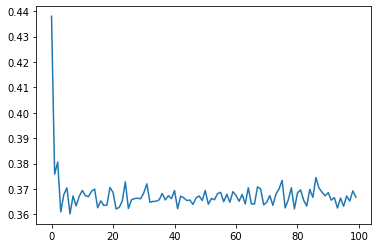

In [32]:
losses = model.fit(loader, val_dataset, epochs=100, verbose=True)

# Plot the accuracy over time
plt.plot(losses)
plt.show()

Let's see how well our model does on a couple images from our validation set:

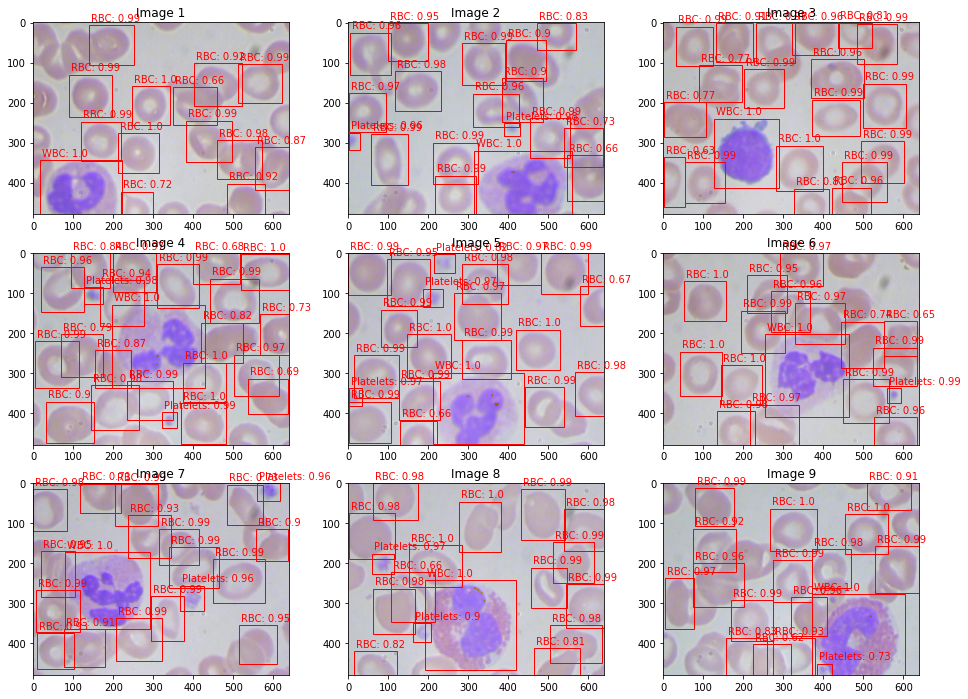

In [33]:
images = []
# Create a list of images 0, 5, 10, ... 40 from val_dataset
for i in range(0, 45, 5):
    image, _ = val_dataset[i]
    images.append(image)

# Plot a 3x3 grid of the model's predictions on our 9 images
visualize.plot_prediction_grid(model, images, dim=(3, 3), figsize=(16, 12))

In [34]:
model.save('model_weights.pth')